# MMI 1 x 4 power splitter

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FMMI_1by4.ipynb).

Optical power splitters are essential components in integrated photonics. Power splitters based on multimode interference (MMI) device are easy to fabricate and can achieve low excess loss as well as large bandwidth. Although the design of a MMI power splitter is based on the self-imaging principle, fine-tuning the geometric parameters with accurate and fast numerical simulations is crucial to achieving optimal device performance. 

This example aims to demonstrate the design and optimization of 1 to 4 MMI device at telecom wavelength for power splitting applications. The initial design is adapted from [D. Malka, Y. Danan, Y. Ramon, Z. Zalevsky, A Photonic 1 x 4 Power Splitter Based on Multimode Interference in Silicon–Gallium-Nitride Slot Waveguide Structures. Materials. 9, 516 (2016)](https://www.mdpi.com/1996-1944/9/7/516).

The device uses a Si-GaN-Si slot waveguide strcuture as schematically shown below.

<img src="img/mmi_schematic.png" width="500" height="500">

## Simulation Setup 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
import jax
from jax.lax import stop_gradient
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run

from tidy3d.plugins import ModeSolver

[16:31:54] INFO     Using client version: 1.8.0                                                     ]8;id=984122;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=116906;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#112\112]8;;\

Define materials. There are three materials involved in this model. The SiO2 cladding and the Si waveguide with GaN slot. All materials are modeled as lossless and dispersionless in this particular case.

In [3]:
si = td.Medium(permittivity = 3.48**2)
gan = td.Medium(permittivity = 2.305**2)
sio2 = td.Medium(permittivity = 1.444**2)

Define initial design parameters and wrap simulation setup in a function. The arguments of the function are the paremeters we want to optimize later. In this example, we aim to optimize the length and width of the MMI section.

In [42]:
W_MMI0 = 5.5 #width of the MMI section
L_MMI0 = 11.0  #length of the MMI section

wg_width =  0.5
wg_spc = 1.0

lda0 = 1.55   #central wavelength
freq0 = td.C_0/lda0  #central frequency
ldas = np.array([lda0])   #wavelength range
freqs = td.C_0/ldas  #frequency range

#buffer spacings in the x and y directions.
buffer_x = 4
buffer_y = 4.5

#define a function that takes the geometric parameters as input arguments and return a Simulation object
def make_sim(L_MMI=L_MMI0, W_MMI=W_MMI0):
    #the whole device is defined as a PolySlab with vertices given by the following

    L_MMI0 = stop_gradient(L_MMI)
    W_MMI0 = stop_gradient(W_MMI)
    
    #simulation domain size
    Lx = W_MMI0 + 2 * buffer_x
    Ly = L_MMI0 + 2 * buffer_y
    sim_size = (Lx, Ly, 0)
    
    wg_in = td.Structure(
        geometry=td.Box(
            size=(wg_width, L_MMI0, td.inf),
            center=(0.0, -Ly/2, 0.0)),
        medium=td.Medium(permittivity=gan.permittivity)
    )
    
    xl = wg_width/2.0 + wg_spc + wg_width + wg_spc/2.0
    xs = [-xl + i * (wg_width + wg_spc) for i in range(4)]
    wg_outs = [td.Structure(
        geometry=td.Box(
            size=(wg_width, L_MMI0, td.inf),
            center=(x0, Ly/2, 0.0)),
        medium=td.Medium(permittivity=gan.permittivity)
    ) for x0 in xs]


    mmi_box = JaxStructure(
        geometry=JaxBox(
            size=(W_MMI, L_MMI, td.inf),
            center=(0.0, 0.0, 0.0)),
        medium=JaxMedium(permittivity=gan.permittivity)
    )


    mode_spec = td.ModeSpec(num_modes=5, target_neff=3)
    
    #add a mode source for excitation
    mode_source = td.ModeSource(
        center=(0, -Ly/2 + buffer_y/3, 0),
        size=(td.inf, 0, td.inf),
        source_time = td.GaussianPulse(
            freq0=freq0,
            fwidth=freq0/10),
        direction='+',
        mode_spec=mode_spec,
        mode_index=0)
    
    #add two mode monitor to monitor the mode profiles at output waveguides
    mode_monitor1 = td.ModeMonitor(
        center = (xs[0],Ly/2 -buffer_y/3,0),
        size = (td.inf, 0, td.inf),
        freqs = freqs,
        mode_spec=mode_spec,
        name='mode1')        
    
    mode_monitor2 = td.ModeMonitor(
        center = (xs[1],Ly/2-buffer_y/3,0),
        size = (td.inf, 0, td.inf),
        freqs = freqs,
        mode_spec=mode_spec,
        name='mode2')    
    
    #add a field monitor to monitor the field distribution
    field_monitor = td.FieldMonitor(
        center = (0,0,0),
        size = (td.inf, td.inf, 0),
        freqs = [freq0],
        name='field'
    )

    sim = JaxSimulation(
            center=(0,0,0),
            size=sim_size,
            grid_spec=td.GridSpec.auto(min_steps_per_wvl=6, wavelength=td.C_0/freq0),
            structures=[wg_in] + wg_outs,
            input_structures=[mmi_box],
            sources=[mode_source],
            monitors=[field_monitor],
            output_monitors=[mode_monitor1, mode_monitor2],
            run_time=3e-11,
            shutoff=1e-8,
            boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
            medium=sio2)    
    return sim

## Initial Design

First, we simulate an initial design using the previously defined design parameters.

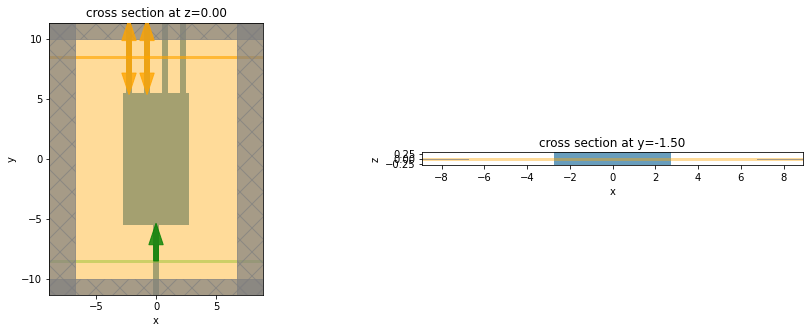

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sim = make_sim(L_MMI0, W_MMI0)
sim.plot(z=0, ax=ax1)
sim.plot(y=-buffer_y/3, ax=ax2)


Before simulation, let's inspect the waveguide modes supported in the slot waveguide to make sure we are using the correct excitation source. 

In [44]:

mode_spec = td.ModeSpec(num_modes=5, target_neff=3)

mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(0, -sim.size[1]/2+buffer_y/3, 0), size=(td.inf, 0, td.inf)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

[16:39:52] WARNING  Mode field at frequency index 0, mode index 4 does not decay at the plane    ]8;id=99475;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=450492;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py#354\354]8;;\
                    boundaries.                                                                                    

The lowest order mode shows a strong field confinement between the Si area. This is the mode we want to use as excitation.

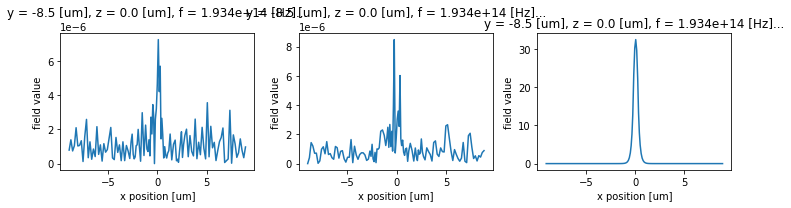

In [45]:
mode_index = 0

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=mode_index)).plot(ax=ax1)
abs(mode_data.Ey.isel(mode_index=mode_index)).plot(ax=ax2)
abs(mode_data.Ez.isel(mode_index=mode_index)).plot(ax=ax3)

# ax1.set_title('|Ex(x, y)|')
# ax1.set_aspect("equal")
# ax2.set_title('|Ey(x, y)|')
# ax2.set_aspect("equal")
# ax3.set_title('|Ez(x, y)|')
# ax3.set_aspect("equal")
plt.show()

Submit simulation job to the server. 

In [46]:
sim = make_sim(L_MMI0, W_MMI0).to_simulation()[0]
job = web.Job(simulation=sim, task_name='mmi')
sim_data = job.run(path='data/simulation_data.hdf5')

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 93.8% • 1.3/1.4 MB • 876.6 kB/s • 0:00:01

[16:40:34] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=879586;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=748539;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#407\407]8;;\

Visualize the field distribution.

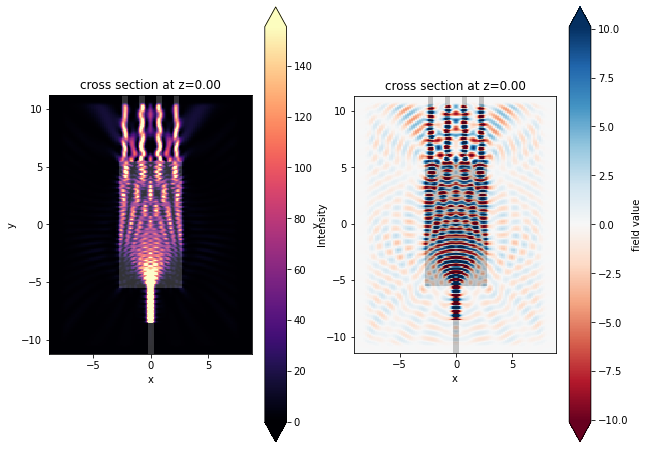

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
sim_data.plot_field('field', 'int', ax = ax1, f=freq0)
sim_data.plot_field('field', 'Ez', ax = ax2, f=freq0)

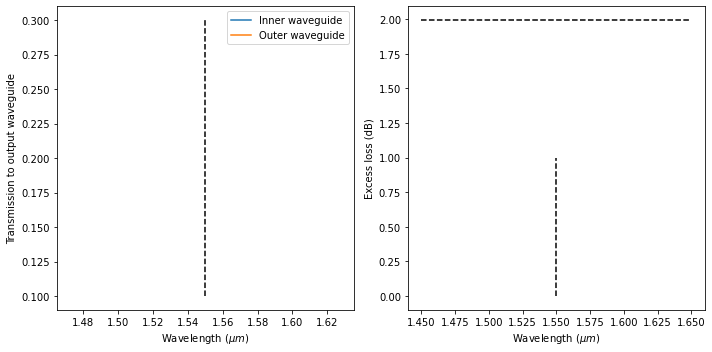

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T1 = sim_data['flux1'].flux
T2 = sim_data['flux2'].flux

plt.sca(ax1)
plt.plot(ldas, T1, ldas, T2)
plt.vlines(x=1.55, ymin=0.1, ymax=0.3, colors='black', ls='--')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Transmission to output waveguide')
plt.legend(('Inner waveguide', 'Outer waveguide'))

plt.sca(ax2)
excess_loss = -10*np.log10(2*(T1+T2))
plt.plot(ldas, excess_loss)
plt.vlines(x=1.55, ymin=0, ymax=1, colors='black', ls='--')
plt.hlines(y=excess_loss[0], xmin=1.45, xmax=1.65, colors='black', ls='--')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Excess loss (dB)')

Plot transmission on each output waveguide as well as the total excess loss. At the central wavelength of 1550 nm, the transimission power at the inner waveguide and outer waveguide differs by about 1%. The excess loss is about 0.4 dB.

We can use the mode monitor to inspect the composition of each mode at the output. For the inner waveguide, we can see that the fundamental mode is dominant and a small amount of Mode 4 is excited.

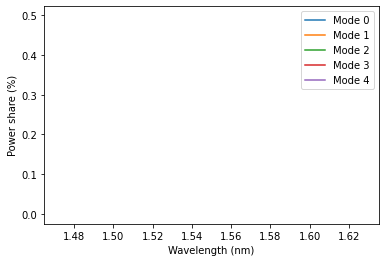

In [10]:
mode_amp = sim_data['mode1'].amps.sel(direction="+")
mode_power = np.abs(mode_amp)**2/T1
plt.plot(ldas, mode_power)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Power share (%)')
plt.legend(["Mode 0", "Mode 1", "Mode 2", "Mode 3", "Mode 4"])

## Optimization 

Further tuning of the geometric parameters is likely to improve the device's performance further. We will perform a parameter sweep on two parameters to see if we can optimize the MMI. The goal is to achieve even power splitting among output waveguides while keeping the excess loss low.

The length of the MMI is swept from 11.1 to 11.2 $\mu m$ in 50 nm step and the width from 4.8 to 5 $\mu m$ in 100 nm step. This results in a total of 9 simulations. Since this is just a demonstration model, we limit the total number of simulations for the sake of time. In practice, one can perform much larger parameter sweeps to cover a larger parameter space.


In [48]:
import jax.numpy as jnp

def objective(L_MMI, W_MMI, step_num=None, J_val=None):
    sim = make_sim(L_MMI, W_MMI)
    
    if step_num and J_val:
        task_name = f"MMI_step{step_num}_J={J_val:.2e}"
    else:
        task_name = "MMI"
    sim_data = run(sim, task_name=task_name)
    
    def get_power(mnt_name: str) -> float:
        """Get power of a mode monitor with name `mnt_name`."""
        amp = sim_data[mnt_name].amps.sel(direction="+", f=freq0, mode_index=0)
        return abs(amp)**2
    
    power1 = get_power('mode1')
    power2 = get_power('mode2')
    
    power_total = power1 + power2
    power_diff = abs(power1 - power2)

    # maximize power transmitted, minimize difference in power
    return power_total**2 - 0.3 * power_diff**2

In [49]:

val_and_grad_objective = jax.value_and_grad(objective, argnums=(0,1))

In [50]:
J, (dL, dW) = val_and_grad_objective(L_MMI0, W_MMI0)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━ 68.9% • 262.1/380.2 kB • ? • -:--:--

[16:41:28] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=44302;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=712556;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#407\407]8;;\

In [51]:
print(J, (dL, dW))

0.6008793 (DeviceArray(-0.63720113, dtype=float32), DeviceArray(2.5018039, dtype=float32))


Parse flux data into numpy arrays.

In [57]:
Js = [J]
args_history = [(L_MMI0, W_MMI0)]

def optimize(
    L_MMI,
    W_MMI,
    step_size=0.1,
    num_steps=10,
    eps_max=5,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):

    args = np.array([L_MMI, W_MMI])
    
    mt = np.zeros((2,))
    vt = np.zeros((2,))

    for i in range(num_steps):

        t = i + 1
        print(f'step = {t}')

        J, (dL, dW) = val_and_grad_objective(*args, step_num=t, J_val=Js[-1])
        gradient = np.array([float(dL), float(dW)])

        mt = beta1 * mt + (1-beta1) * gradient
        vt = beta2 * vt + (1-beta2) * gradient**2

        mt_hat = mt / (1 - beta1**t)
        vt_hat = vt / (1 - beta2**t)

        update = step_size * (mt_hat / np.sqrt(vt_hat) + epsilon)

        Js.append(J)
        print(f'\tJ = {J:.4e}')
        print(f'\tgrad_norm = {np.linalg.norm(gradient):.4e}')

        args += update
        args_history.append((args[0], args[1]))

    return args[0], args[1]

In [58]:
L_MMI_final, W_MMI_final = optimize(L_MMI0, W_MMI0)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 70.5% • 262.1/371.9 kB • ? • -:--:--

[17:00:12] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=423961;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=749329;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#407\407]8;;\

	J = 8.2965e-01
	grad_norm = 6.4151e-02


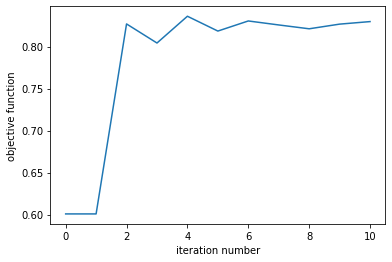

In [74]:
plt.plot(Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')

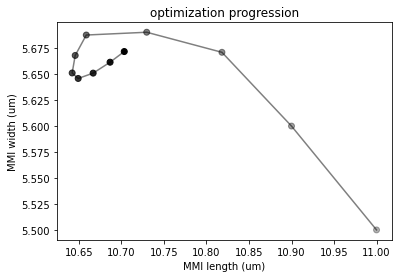

In [73]:
args = np.array(args_history)

Ls, Ws = args.T

alphas = np.linspace(0.3, 1, len(Ls))

plt.scatter(Ls, Ws, color='k', alpha=alphas)
plt.plot(Ls, Ws, color='k', alpha=0.5)
plt.xlabel('MMI length (um)')
plt.ylabel('MMI width (um)')
plt.title('optimization progression')
plt.show()


In [65]:
sim = make_sim(*args[-1]).to_simulation()[0]
job = web.Job(simulation=sim, task_name='mmi')
sim_data = job.run(path='data/simulation_data.hdf5')


↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 57.0% • 0.8/1.4 MB • 2.4 MB/s • 0:00:01

[17:04:46] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=907708;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380174;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#407\407]8;;\

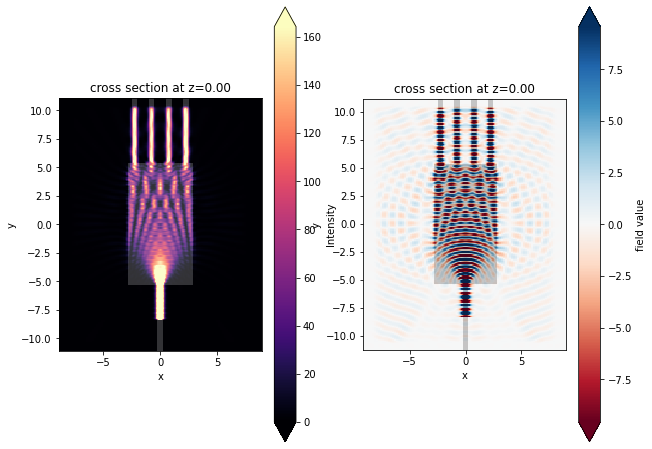

In [66]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
sim_data.plot_field('field', 'int', ax = ax1, f=freq0)
sim_data.plot_field('field', 'Ez', ax = ax2, f=freq0)